<a href="https://colab.research.google.com/github/dhruv354/cifar/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow
import tensorflow.keras as keras
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import  Flatten, Dense
from keras.datasets import cifar10

In [2]:
from keras import Sequential

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape

170500096/170498071 [==============================] - 2s 0us/step


(50000, 32, 32, 3)

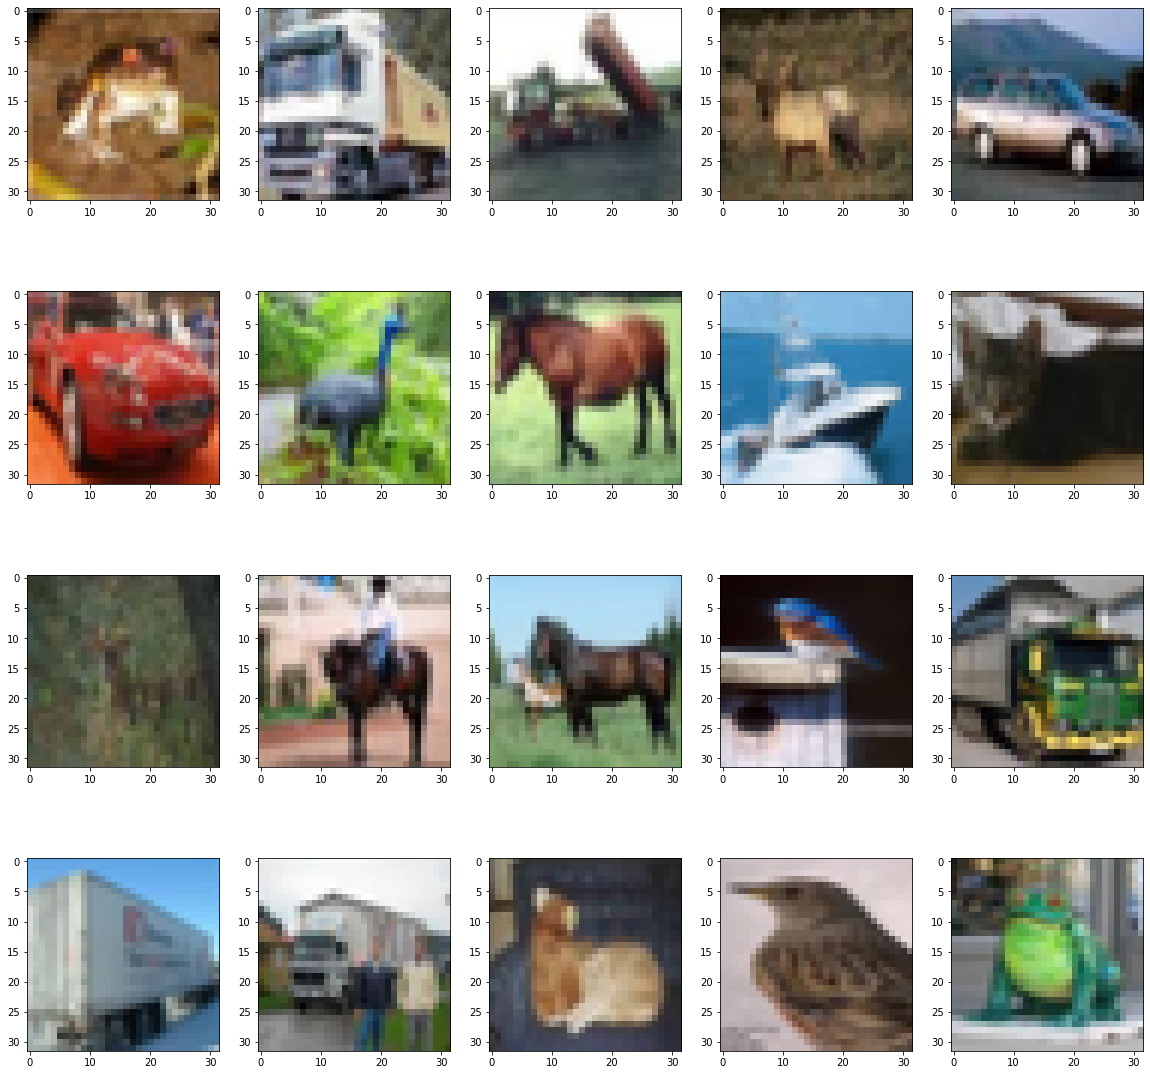

In [4]:
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize=(20, 20))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(X_train[i])

In [5]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [6]:
!pip install keras-tuner -q


     |████████████████████████████████| 71kB 4.0MB/s 


In [14]:
#building model
def build_model(hp):
  model = Sequential([
      #first set of layers                
      Conv2D(
          filters = hp.Int('conv1_numfilters', min_value=32, max_value=64, step=16),
          kernel_size = hp.Choice('conv1_filter', values=[3, 4, 5]),
          padding = 'same',
          activation='relu',
          input_shape=(32, 32, 3)
      ),
      MaxPooling2D(pool_size = hp.Choice('maxpooling_1', values=[2, 4])),
      Dropout(hp.Float(name='dropout', min_value=0.3, max_value=0.58, step=0.1)),
      #second set of layers
      Conv2D(
          filters = hp.Int('conv1_numfilters', min_value=64, max_value=128, step=32),
          kernel_size = hp.Choice('conv1_filter', values=[3, 4, 5]),
          padding = 'same',
          activation='relu'
      ),
      MaxPooling2D(pool_size = hp.Choice( 'maxpooling_2', values=[2, 4])),
      Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.58, step=0.1)),
      #flattening of Layer
      Flatten(),
      Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=64), activation='relu'),
      Dense(units=10, activation='softmax')
  ])
  model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [8]:
!mkdir my_project


In [15]:
from kerastuner import Hyperband
tuner_search = Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    max_epochs=2,
    directory = 'my_project',
    project_name='cifar10_keras'
)
tuner_search.search(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Trial 2 Complete [00h 00m 15s]
val_accuracy: 0.5913000106811523

Best val_accuracy So Far: 0.5917999744415283
Total elapsed time: 00h 00m 38s
INFO:tensorflow:Oracle triggered exit


In [16]:
tuner_search.results_summary()

Results summary
Results in my_project/cifar10_keras
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv1_numfilters: 48
conv1_filter: 5
maxpooling_1: 2
dropout: 0.5
maxpooling_2: 2
dropout_2: 0.5
units_1: 128
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.5917999744415283
Trial summary
Hyperparameters:
conv1_numfilters: 48
conv1_filter: 4
maxpooling_1: 2
dropout: 0.5
maxpooling_2: 4
dropout_2: 0.3
units_1: 128
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.5913000106811523


In [18]:
best_hps=tuner_search.get_best_hyperparameters(num_trials=1)[0]

In [19]:
model = tuner_search.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.8425 - accuracy: 0.3221 - val_loss: 1.3479 - val_accuracy: 0.5283
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3355 - accuracy: 0.5181 - val_loss: 1.1707 - val_accuracy: 0.6008
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2011 - accuracy: 0.5693 - val_loss: 1.1104 - val_accuracy: 0.6157
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1078 - accuracy: 0.6038 - val_loss: 1.0639 - val_accuracy: 0.6258
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0488 - accuracy: 0.6301 - val_loss: 0.9726 - val_accuracy: 0.6585
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0081 - accuracy: 0.6447 - val_loss: 1.0089 - val_accuracy: 0.6451
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9625 - accuracy: 0.6611 - val_loss: 0.9010 - val_accuracy:

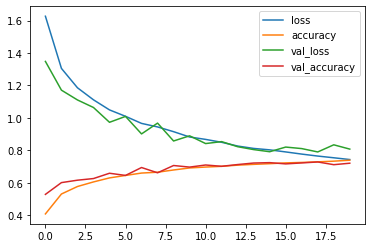

In [20]:
import pandas as pd
df = pd.DataFrame(history.history)
df.plot()

In [21]:
#performing data augmentation
# create data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(X_train, y_train, batch_size=64)


In [22]:
history2 = model.fit(it_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
782/782 [==============================] - 23s 29ms/step - loss: 0.9694 - accuracy: 0.6595 - val_loss: 0.7908 - val_accuracy: 0.7314
Epoch 2/20
782/782 [==============================] - 22s 28ms/step - loss: 0.9440 - accuracy: 0.6693 - val_loss: 0.8271 - val_accuracy: 0.7130
Epoch 3/20
782/782 [==============================] - 22s 28ms/step - loss: 0.9305 - accuracy: 0.6737 - val_loss: 0.8048 - val_accuracy: 0.7216
Epoch 4/20
782/782 [==============================] - 22s 28ms/step - loss: 0.9218 - accuracy: 0.6784 - val_loss: 0.7902 - val_accuracy: 0.7335
Epoch 5/20
782/782 [==============================] - 22s 28ms/step - loss: 0.9161 - accuracy: 0.6755 - val_loss: 0.8704 - val_accuracy: 0.6996
Epoch 6/20
782/782 [==============================] - 22s 28ms/step - loss: 0.9085 - accuracy: 0.6840 - val_loss: 0.7684 - val_accuracy: 0.7372
Epoch 7/20
782/782 [==============================] - 22s 28ms/step - loss: 0.9058 - accuracy: 0.6815 - val_loss: 0.7651 - val_accuracy:

In [23]:
temp = iter(it_train)
print(len(temp))

782


In [42]:
#using transfer learning on CIFAR dataset
from keras.applications.resnet50 import ResNet50
RESNET50_layers = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3), classes=10)
model1 = Sequential()
model1.add(RESNET50_layers)
model1.add(Flatten())
model1.add(Dense(units=512, activation='relu'))
#model1.add(Dropout(0.3))
model1.add(Dense(units=256, activation='relu'))
#model1.add(Dropout(0.3))
model1.add(Dense(units=10, activation='softmax'))
model1.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                2570      
Total params: 24,770,698
Trainable params: 24,717,578
Non-trainable params: 53,120
_________________________________________________________________


In [43]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
history3 = model1.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
1563/1563 [==============================] - 92s 59ms/step - loss: 0.7846 - accuracy: 0.7318 - val_loss: 0.8071 - val_accuracy: 0.7365
Epoch 2/5
1563/1563 [==============================] - 92s 59ms/step - loss: 0.7697 - accuracy: 0.7440 - val_loss: 1.5190 - val_accuracy: 0.5037
Epoch 3/5
1563/1563 [==============================] - 92s 59ms/step - loss: 0.7026 - accuracy: 0.7656 - val_loss: 1.1042 - val_accuracy: 0.6256
Epoch 4/5
1563/1563 [==============================] - 92s 59ms/step - loss: 0.8300 - accuracy: 0.7226 - val_loss: 1.1132 - val_accuracy: 0.6640
Epoch 5/5
1563/1563 [==============================] - 92s 59ms/step - loss: 0.8150 - accuracy: 0.7216 - val_loss: 0.9786 - val_accuracy: 0.6851


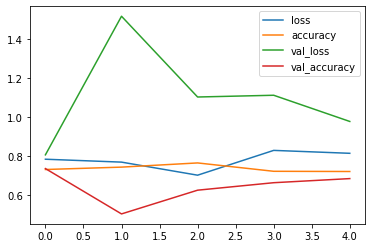

In [48]:
import pandas as pd
pd.DataFrame(history3.history).plot()